# Simulation I

Here, we will apply and compare a sparse approach with variational inference to GPC ([Hensman et al., 2015](https://arxiv.org/abs/1411.2005)) to a simulated 1-D dataset of varying sizes. We will call this method "SVGP" and compare it with:

1. An approach to GPC with variational inference only (FVGP).
2. An approahc to GPC with Laplace approximations (LGP).
3. Logistc regression (LR).

In [3]:
%pylab inline
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt

#Importing  further necessary modules

import time
import pickle
import GPy
import numpy as np
import pandas as pd
from statsmodels.tools import add_constant
import statsmodels.api as sm
from scipy.special import expit, logit
from scipy import optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
#PLotting specifications

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#import matplotlib;matplotlib.rcParams['text.usetex'] = True
import matplotlib;matplotlib.rcParams['font.size'] = 16
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'

## Setting Up Simulation Data

Here, we will set up our simulated data. 

Firstly we set up our data, $X$. 
This consists of $n$ random uniform draws scaled by 11, such that the data points lie in $[0,11)$. We take $n$ to be $150, 500, 1000, 1500$. <br>
We then apply the latent function $f$ to $X$: $$f(x) = 3(\sin^4(x)+\cos^3(x))$$.

Next, we transform the latent function values $f$ to probabilities via the logistic function. This is stored in $p$.
In order to set up the simulation data, we then random assign classes ($0$ or $1$) to our data. This is done by comparing the probabilities to an array of randomly generated probabilities, and assigning $1$ where the probability is less than the generated probability, and $0$ otherwise.

In order to allow for the sparse methods, we also draw inducing points, $Z$, like for $X$. <br>
Here, we take the inducing points to be $10\%$ of $n$.

In [4]:
np.random.seed(42)             #to make it reproducible

N = [150, 500, 1000, 1500]
scale_factor = 11             #scale factor for uniform draws
datasets = []
for n in N:

    X = np.random.rand(n,1)*scale_factor    #draws from uniform distribution on [0,1) scaled by 11; data
    f = 3*np.sin(X)**4+3*np.cos(X)**3
    p = np.exp(f)/(1+np.exp(f))      #Applying logistic function to f to return probabilities
    Y = np.where(p>np.random.rand(*p.shape), 1,0)    #assign classes
    
    M = int(0.1*0.75*n)
    Z = np.random.rand(M,1)*scale_factor        #draws fron uniform distribution scaled by 11; inducing points

    dataset = [X,Y,Z,f,p]
    datasets += [dataset]


In [341]:
for i, dataset in enumerate(datasets):

    print(f"Sizes of data {i}")
    print(f"X: {dataset[0].shape}, f:{dataset[3].shape}, p: {dataset[4].shape}\nY:{dataset[1].shape}, Z:{dataset[2].shape}")
    print("\n")

Sizes of data 0
X: (150, 1), f:(150, 1), p: (150, 1)
Y:(150, 1), Z:(11, 1)


Sizes of data 1
X: (500, 1), f:(500, 1), p: (500, 1)
Y:(500, 1), Z:(37, 1)


Sizes of data 2
X: (1000, 1), f:(1000, 1), p: (1000, 1)
Y:(1000, 1), Z:(75, 1)


Sizes of data 3
X: (1500, 1), f:(1500, 1), p: (1500, 1)
Y:(1500, 1), Z:(112, 1)




In [5]:
#Test-train split 25-75%

from sklearn.model_selection import train_test_split

test_train_splits = []
for i in range(len(N)):

    split_1 = train_test_split(datasets[i][0], datasets[i][1], test_size=0.25, random_state=42)
    split_2 = train_test_split(datasets[i][3], datasets[i][4], test_size=0.25, random_state=42)
    test_train_splits += [[split_1, split_2]]
    

In [14]:
for i, split in enumerate(test_train_splits):
    
    print(f"Sizes of training and test data {i}")
    print(f"X_train: {split[0][0].shape}, X_test: {split[0][1].shape}")
    print("\n")

Sizes of training and test data 0
X_train: (112, 1), X_test: (38, 1)


Sizes of training and test data 1
X_train: (375, 1), X_test: (125, 1)


Sizes of training and test data 2
X_train: (750, 1), X_test: (250, 1)


Sizes of training and test data 3
X_train: (1125, 1), X_test: (375, 1)




## Plotting Largest Dataset

In [6]:
#Ordering variables of largest dataset for plotting

#Full dataset, using 10% inducing points

#dataset = [X,Y,Z,f,p]
X_larg = datasets[3][0]
Y_larg = datasets[3][1]
Z_larg_10 = datasets[3][2]
f_larg = datasets[3][3]
p_larg = datasets[3][4]

order_full_larg = np.argsort(X_larg[:,0])
X_larg_full_ordered = X_larg[order_full_larg]
f_larg_full_ordered = f_larg[order_full_larg]
p_larg_full_ordered = p_larg[order_full_larg]

#Train set

#split = [[X_train, X_test, Y_train, Y_test], [f_train, f_test, p_train, p_test]]
X_train_larg = test_train_splits[3][0][0]
Y_train_larg = test_train_splits[3][0][2]
f_train_larg = test_train_splits[3][1][0]
p_train_larg = test_train_splits[3][1][2]

order_train_larg = np.argsort(X_train_larg[:,0])
X_train_larg_ordered = X_train_larg[order_train_larg]
f_train_larg_ordered = f_train_larg[order_train_larg]
p_train_larg_ordered = p_train_larg[order_train_larg]

#Test set

X_test_larg = test_train_splits[3][0][0]
Y_test_larg = test_train_splits[3][0][2]
f_test_larg = test_train_splits[3][1][0]
p_test_larg = test_train_splits[3][1][2]

order_test_larg = np.argsort(X_test_larg[:,0])
X_test_larg_ordered = X_test_larg[order_test_larg]
f_test_larg_ordered = f_test_larg[order_test_larg]
p_test_larg_ordered = p_test_larg[order_test_larg]

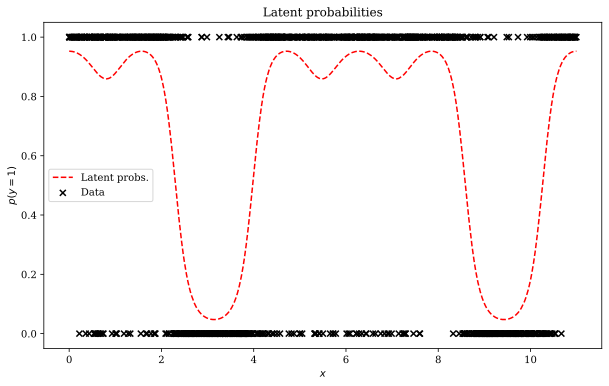

In [18]:
#Plotting latent probabilitites of entire dataset

plt.plot(X_larg_full_ordered, p_larg_full_ordered, color="red", ls="--")
plt.scatter(X_larg,Y_larg, color="black", marker="x")
plt.title('Latent probabilities')
plt.xlabel('$x$')
plt.ylabel('$p(y=1)$')
plt.legend( ['Latent probs.', "Data"], loc="best")
plt.savefig("Simulation_1_largest_dataset", dpi=100)

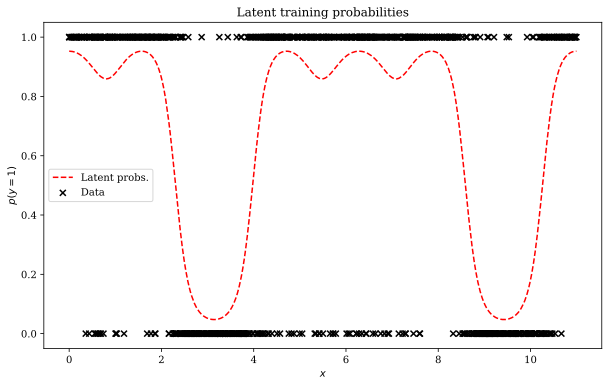

In [34]:
#Plotting latent probabilitites of training set

plt.plot(X_train_larg_ordered, p_train_larg_ordered, color="red", ls="--")
plt.scatter(X_train_larg, Y_train_larg, color="black", marker="x")
plt.title('Latent training probabilities')
plt.xlabel('$x$')
plt.ylabel('$p(y=1)$')
plt.legend( ['Latent probs.', "Data"], loc="best")
plt.savefig("Simulation_1_largest_dataset_train", dpi=100)

## GP Variational Classification for Largest Dataset

### SVGP (10% Inducing)

In [16]:
#Stochastic Variational GP model, with sparse approximations 

m = GPy.core.SVGP(X_train_larg, Y_train_larg, kernel=GPy.kern.RBF(1)+GPy.kern.White(1), likelihood=GPy.likelihoods.Bernoulli(), Z=Z_larg_10)

In [2]:
#Optimizing model and plotting model probabilities

mean_t = 0
for i in range(5):
    
    t0 = time.time()
    m.optimize('bfgs')
    t1 = time.time()
    mean_t += t1-t0

mean_t = mean_t/5

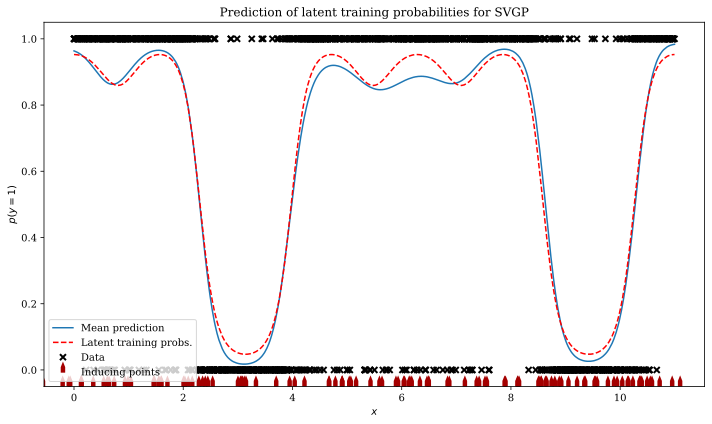

In [18]:
#Plotting latent training probaility predictions

plot_predict = m.predict(X_test_larg_ordered)[0]

m.plot_inducing()
plt.plot(X_test_larg_ordered, plot_predict)
plt.plot(X_train_larg_ordered, p_train_larg_ordered, color="red", ls="--")   #actual plot of probabilities
plt.plot(X, Y, 'kx', mew=2)
plt.xlabel("$x$")
plt.ylabel("$p(y=1)$")
plt.title("Prediction of latent training probabilities for SVGP")
plt.legend( ['Mean prediction', 'Latent training probs.', "Data", "Inducing points"], loc="lower left")
plt.savefig("Simulation_1_largest_10%_prediction_latent_probs_SVGP", dpi=100)

In [10]:
#Time taken

print(f'Mean Time taken for SVGP: {mean_t}')

Mean Time taken for SVGP: 29.515296936035156


In [300]:
#Saving mean times

time_comps = {"SVGP": {150:0, 500:0, 1000: 0, 1500:0}, 
              "FVGP": {150:0, 500:0, 1000:0, 1500:0}, 
              "LGP": {150:0, 500:0, 1000:0, 1500:0}, 
              "LR": {150:0, 500:0, 1000:0, 1500:0}}

time_comps["SVGP"][1500] = mean_t

In [301]:
#Correct classification rate (CRR)

X_test_larg = test_train_splits[3][0][1]
Y_test_larg = test_train_splits[3][0][3]

predict_sparse_var = m.predict(X_test_larg)[0]
classification_sparse_var = np.where(predict_sparse_var >= 0.5, 1, 0)
CRR_sparse_var = np.where(classification_sparse_var == Y_test_larg)[0].size/Y_test_larg.size    #corect classification rate

In [302]:
#Saving CRR

CRRs = {"SVGP": {150:0, 500:0, 1000: 0, 1500: 0}, 
              "FVGP": {150:0, 500:0, 1000:0, 1500:0}, 
              "LGP": {150:0, 500:0, 1000:0, 1500:0}, 
              "LR": {150:0, 500:0, 1000:0, 1500:0}}

CRRs["SVGP"][1500] = CRR_sparse_var

In [303]:
#Model output 

m

SVGP.,value,constraints,priors
inducing inputs,"(112, 1)",,
sum.rbf.variance,2.919864473015653,+ve,
sum.rbf.lengthscale,0.8037922666621832,+ve,
sum.white.variance,0.0001559724812164244,+ve,
q_u_chol,"(6328, 1)",,
q_u_mean,"(112, 1)",,


### FVGP

In [7]:
#Full model, without sparse approximations

m = GPy.models.GPVariationalGaussianApproximation(X_train_larg, Y_train_larg, kernel=GPy.kern.RBF(1)+GPy.kern.White(1), likelihood=GPy.likelihoods.Bernoulli())

In [5]:
#Optimizing model and plotting model probabilities

mean_t = 0
for i in range(5):
    
    t0 = time.time()
    m.optimize('bfgs')
    t1 = time.time()
    mean_t += t1-t0

mean_t = mean_t/5

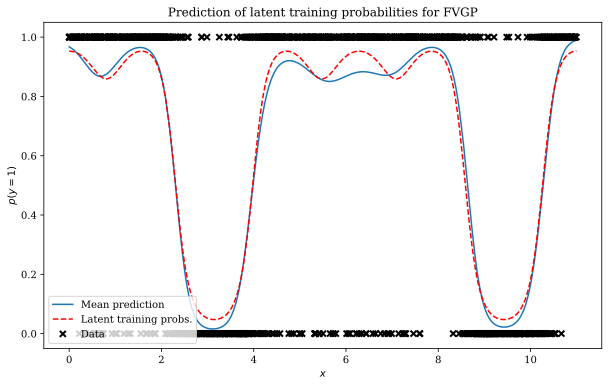

In [9]:
#Plotting latent training probaility predictions

plot_predict = m.predict(X_test_larg_ordered)[0]

plt.plot(X_test_larg_ordered, plot_predict)
plt.plot(X_train_larg_ordered, p_train_larg_ordered, color="red", ls="--")   #actual plot of probabilities
plt.plot(X, Y, 'kx', mew=2)
plt.xlabel("$x$")
plt.ylabel("$p(y=1)$")
plt.title("Prediction of latent training probabilities for FVGP")
plt.legend( ['Mean prediction', 'Latent training probs.', "Data"], loc="lower left")
plt.savefig("Simulation_1_largest_prediction_latent_probs_FVGP", dpi=100)

In [11]:
#Time taken

print(f'Mean time taken for FVGP: {mean_t}')

Mean time taken for FVGP: 256.47870659828186


In [307]:
#Saving times

time_comps["FVGP"][1500] = mean_t

In [308]:
#Classification rate (CRR)

predict_full_var = m.predict(X_test_larg)[0]
classification_full_var = np.where(predict_full_var >= 0.5, 1, 0)
CRR_full_var = np.where(classification_full_var == Y_test_larg)[0].size/Y_test_larg.size    #corect classification rate

In [309]:
#Saving CRR

CRRs["FVGP"][1500] = CRR_full_var

In [310]:
#Model output

m

VarGP.,value,constraints,priors
sum.rbf.variance,3.8033062241471165,+ve,
sum.rbf.lengthscale,0.8941130606424255,+ve,
sum.white.variance,0.0006768093993949646,+ve,
alpha,"(1125, 1)",,
beta,"(1125,)",,


## LGP for Largest Dataset

In [40]:
#Obtaining probabilities for Laplacian method

lik = GPy.likelihoods.Bernoulli()    #Bernoulli likelihood

In [41]:
#Creating Laplacian inference model

kl = GPy.kern.RBF(1, variance=1., lengthscale=1)+GPy.kern.White(1)        #Kernel with specific legnthscale and variance, both set to units
laplace_inf = GPy.inference.latent_function_inference.Laplace()
m = GPy.core.GP(X=X_train_larg,
                Y=Y_train_larg, 
                kernel=kl, 
                inference_method=laplace_inf,
                likelihood=lik)

In [42]:
#Optimizing model and plotting model probabilities

mean_t = 0
for i in range(5):
    
    t0 = time.time()
    m.optimize('bfgs')
    t1 = time.time()
    mean_t += t1-t0

mean_t = mean_t/5

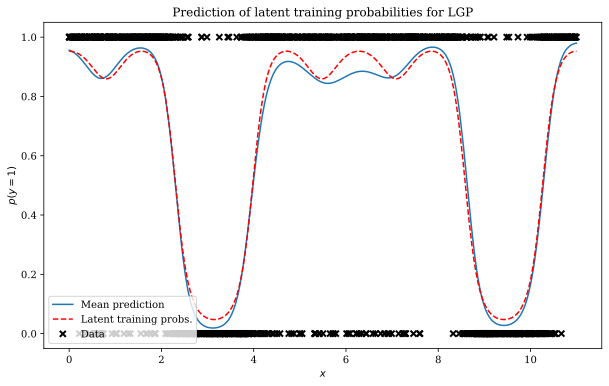

In [48]:
#Plotting latent training probaility predictions

plot_predict = m.predict(X_test_larg_ordered)[0]

plt.plot(X_test_larg_ordered, plot_predict)
plt.plot(X_train_larg_ordered, p_train_larg_ordered, color="red", ls="--")   #actual plot of probabilities
plt.plot(X, Y, 'kx', mew=2)
plt.xlabel("$x$")
plt.ylabel("$p(y=1)$")
plt.title("Prediction of latent training probabilities for LGP")
plt.legend( ['Mean prediction', 'Latent training probs.', "Data"], loc="lower left")
plt.savefig("Simulation_1_largest_optimized_prediction_latent_probs_LGP", dpi=100)

In [12]:
#Time taken

print(f'Mean time taken for LGP: {mean_t}')

Mean time taken for LGP: 55.28310966491699


In [316]:
#Saving times

time_comps["LGP"][1500] = mean_t

In [317]:
#Classification rate (CRR)

predict_laplace = m.predict(X_test_larg)[0]
classification_laplace = np.where(predict_laplace >= 0.5, 1, 0)
CRR_laplace = np.where(classification_laplace == Y_test_larg)[0].size/Y_test_larg.size    #corect classification rate

In [318]:
#Saving CRR

CRRs["LGP"][1500] = CRR_laplace

In [319]:
#Model output

m

gp.,value,constraints,priors
sum.rbf.variance,2.9655239114673493,+ve,
sum.rbf.lengthscale,0.8078074033198658,+ve,
sum.white.variance,5.917033747565433e-07,+ve,


## LR for Largest Dataset

In [60]:
#Fitting logistic regression model with logit link, including intercept term

X_train_larg_design = add_constant(X_train_larg)
mean_t = 0
for i in range(5):
    t0 = time.time()
    m = sm.Logit(Y_train_larg, X_train_larg_design).fit()
    t1 = time.time()
    mean_t += t1 - t0
    
mean_t = mean_t/5

In [104]:
#Making predictions of latent probabilities on training set

s = X_train_larg_design.shape
predictions = m.predict(X_train_larg_design).reshape(s[0],1)

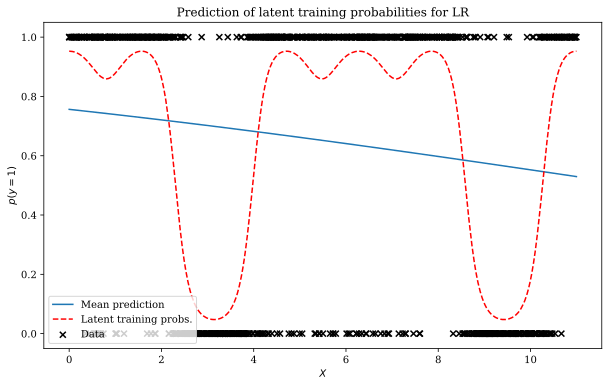

In [64]:
#Plotting latent training probaility predictions

#Ordering for plotting

ordered_pred = predictions[order_train_larg]                      #ordering probability predictions



plt.plot(X_train_larg_ordered, ordered_pred)
plt.scatter(X_train_larg, Y_train_larg, marker="x", color="black")
plt.plot(X_train_larg_ordered, p_train_larg_ordered, color="red", ls="--")


plt.xlabel("$X$")
plt.ylabel("$p(y=1)$")
plt.title("Prediction of latent training probabilities for LR")
plt.legend( ['Mean prediction', 'Latent training probs.', "Data"], loc="lower left")
plt.savefig("Simulation_1_largest_prediction_latent_probs_LR", dpi=100)

In [321]:
#Time taken

print(f'Mean time taken for LR: {mean_t}')

Mean time taken for LR: 0.0049970149993896484


In [325]:
#Saving times

time_comps["LR"][1500] = mean_t

In [326]:
#Classification rate (CRR)

X_test_larg_design = add_constant(X_test_larg)
s = X_test_larg_design.shape

predict_logistic = m.predict(X_test_larg_design).reshape(s[0], 1)
classification_logistic = np.where(predict_logistic >= 0.5, 1, 0)
CRR_logistic = np.where(classification_logistic == Y_test_larg)[0].size/Y_test_larg.size    #corect classification rate

In [327]:
#Saving CRR

CRRs["LR"][1500] = CRR_logistic

In [328]:
#Model output

m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1125
Model:                          Logit   Df Residuals:                     1123
Method:                           MLE   Df Model:                            1
Date:                Mon, 28 Dec 2020   Pseudo R-squ.:                 0.01468
Time:                        14:01:02   Log-Likelihood:                -717.23
converged:                       True   LL-Null:                       -727.91
Covariance Type:            nonrobust   LLR p-value:                 3.783e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1333      0.131      8.678      0.000       0.877       1.389
x1            -0.0923      0.020     -4.582      0.000      -0.132      -0.053
==============================================================================
"""

## Performance and Computation Time for All Datasets

In [333]:
#Finding computation time and performance for all dataset (except from the largest which was already found)

for i, split in enumerate(test_train_splits[:-1]):

    n = N[i]
    X_train = split[0][0]
    X_test = split[0][1]
    Y_train = split[0][2]
    Y_test = split[0][3]
    Z_i = datasets[i][2]

    #SVGP
    m = GPy.core.SVGP(X_train, Y_train, kernel=GPy.kern.RBF(1)+GPy.kern.White(1), likelihood=GPy.likelihoods.Bernoulli(), Z=Z_i)
    mean_t = 0
    for i in range(5):
        
        t0 = time.time()
        m.optimize("bfgs")
        t1 = time.time()
        mean_t += t1-t0
    mean_t = mean_t/5

    predict_SVGP = m.predict(X_test)[0]
    classification_SVGP = np.where(predict_SVGP >= 0.5, 1, 0)
    CRR_SVGP = np.where(classification_SVGP == Y_test)[0].size/Y_test.size    #corect classification rate

    time_comps["SVGP"][n] = mean_t
    CRRs["SVGP"][n] = CRR_SVGP

    #FVGP
    m = GPy.models.GPVariationalGaussianApproximation(X_train, Y_train, kernel=GPy.kern.RBF(1)+GPy.kern.White(1), likelihood=GPy.likelihoods.Bernoulli())
    mean_t = 0
    for i in range(5):
        
        t0 = time.time()
        m.optimize("bfgs")
        t1 = time.time()
        mean_t += t1-t0
    mean_t = mean_t/5

    predict_FVGP = m.predict(X_test)[0]
    classification_FVGP = np.where(predict_FVGP >= 0.5, 1, 0)
    CRR_FVGP = np.where(classification_FVGP == Y_test)[0].size/Y_test.size    #corect classification rate

    time_comps["FVGP"][n] = mean_t
    CRRs["FVGP"][n] = CRR_FVGP

    #LGP
    lik = GPy.likelihoods.Bernoulli()    #Bernoulli likelihood
    kl = GPy.kern.RBF(1, variance=1., lengthscale=1)+GPy.kern.White(1)        #Kernel with specific legnthscale and variance, both set to units
    laplace_inf = GPy.inference.latent_function_inference.Laplace()
    m = GPy.core.GP(X=X_train, Y=Y_train, kernel=kl, inference_method=laplace_inf, likelihood=lik)
    
    mean_t = 0
    for i in range(5):
        
        t0= time.time()
        m.optimize('bfgs', max_iters=100)
        t1 = time.time()
        mean_t += t1-t0
    mean_t = mean_t/5

    predict_LGP = m.predict(X_test)[0]
    classification_LGP = np.where(predict_LGP >= 0.5, 1, 0)
    CRR_LGP = np.where(classification_LGP == Y_test)[0].size/Y_test.size    #corect classification rate

    time_comps["LGP"][n] = mean_t
    CRRs["LGP"][n] = CRR_LGP

    #LR
    X_train_design = add_constant(X_train)
    mean_t = 0
    for i in range(5):
        
        t0 = time.time()
        m = sm.Logit(Y_train, X_train_design).fit()
        t1 = time.time()
        mean_t += t1-t0
    mean_t = mean_t/5

    X_test_design = add_constant(X_test)
    s = X_test_design.shape

    predict_LR = m.predict(X_test_design).reshape(s[0],1)
    classification_LR = np.where(predict_LR >= 0.5, 1, 0)
    CRR_LR = np.where(classification_LR == Y_test)[0].size/Y_test.size    #corect classification rate
    
    time_comps["LR"][n] = mean_t
    CRRs["LR"][n] = CRR_LR

## Results

Here we will create plots of:
    
1. Mean computation time against data size
2. CRR against data size.

for all our models.

In [8]:
#Plot of training no. against computation time.

#Getting computation and CRRs for models

sizes = [150, 500, 1000, 1500]
models = list(time_comps.keys())
SVGP_times = []
FVGP_times = []
LGP_times = []
LR_times = []

SVGP_CRRs = []
FVGP_CRRs = []
LGP_CRRs = []
LR_CRRs = []

for model in models:
    
    if model == "SVGP":
        
        times = list(time_comps[model].values())[0:3]+[time_comps[model][1500]]
        SVGP_times += times
        
        CRRs_model = list(CRRs[model].values())[0:3]+[CRRs[model][1500]]
        SVGP_CRRs += CRRs_model
    elif model == "FVGP":
        
        times = list(time_comps[model].values())
        FVGP_times += times
        
        CRRs_model = list(CRRs[model].values())
        FVGP_CRRs += CRRs_model
    elif model == "LGP":
        
        times = list(time_comps[model].values())
        LGP_times += times
        
        CRRs_model = list(CRRs[model].values())
        LGP_CRRs += CRRs_model
    else:
        
        times = list(time_comps[model].values())
        LR_times += times
        
        CRRs_model = list(CRRs[model].values())
        LR_CRRs += CRRs_model
    
    
    

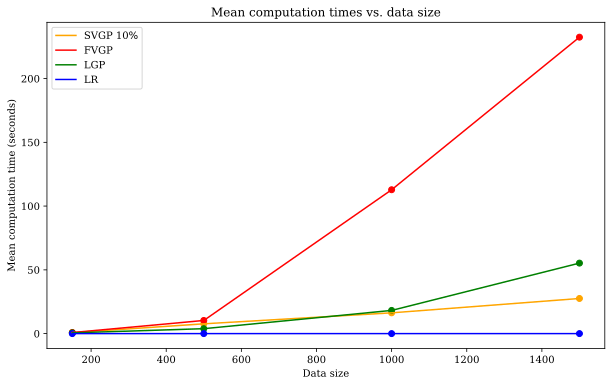

In [63]:
#Plot of data size against computation times

plt.plot(sizes, SVGP_times, color="orange", ls="-", label="SVGP 10$\%$")
plt.scatter(sizes, SVGP_times, color="orange")

plt.plot(sizes, FVGP_times, color="red", ls="-", label="FVGP")
plt.scatter(sizes, FVGP_times, color="red")

plt.plot(sizes, LGP_times, color="green", ls="-", label="LGP")
plt.scatter(sizes, LGP_times, color="green")

plt.plot(sizes, LR_times, color="blue", ls="-", label="LR")
plt.scatter(sizes, LR_times, color="blue")

plt.title('Mean computation times vs. data size')
plt.xlabel('Data size')
plt.ylabel('Mean computation time (seconds)')
plt.legend(loc="best")
plt.savefig("Simulation_8_train_size_vs_time", dpi=100)
#plt.plot(X, p, 'r.')

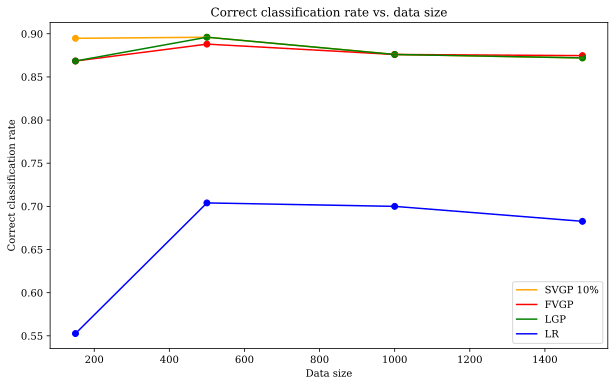

In [10]:
#Plot of data size against CRRs

plt.plot(sizes, SVGP_CRRs, color="orange", ls="-", label="SVGP 10$\%$")
plt.scatter(sizes, SVGP_CRRs, color="orange")

plt.plot(sizes, FVGP_CRRs, color="red", ls="-", label="FVGP")
plt.scatter(sizes, FVGP_CRRs, color="red")

plt.plot(sizes, LGP_CRRs, color="green", ls="-", label="LGP")
plt.scatter(sizes, LGP_CRRs, color="green")

plt.plot(sizes, LR_CRRs, color="blue", ls="-", label="LR")
plt.scatter(sizes, LR_CRRs, color="blue")

plt.title('Correct classification rate vs. data size')
plt.xlabel('Data size')
plt.ylabel('Correct classification rate')
plt.legend(loc="best")
plt.savefig("Simulation_7_CRR_vs_size", dpi=100)
#plt.plot(X, p, 'r.')